# CREAR NUEVAS TABLAS POR VUELO y MODELO DE COMBUSTIBLE

In [2]:
import psycopg2

conn = psycopg2.connect(database="pointclouds",
                        host="172.17.0.2",
                        user="postgres",
                        password="ventanuco",
                        port="5432")

In [3]:
import geopandas as gpd

vuelo = 'vuelo1'
z = 1

fm = gpd.read_postgis(f'select * from fm_{vuelo}_zona{z}', conn, geom_col='geometry')

modelos = fm.value.unique()

/home/nano/anaconda3/envs/pdal/lib/python3.12/site-packages/geopandas/io/sql.py:185: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(
/home/nano/anaconda3/envs/pdal/lib/python3.12/site-packages/geopandas/io/sql.py:463: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(spatial_ref_sys_sql, con)


In [ ]:
cursor = conn.cursor()
cursor.execute(f'select pcid from pointcloud_columns where "table" = \'{vuelo}_zona{1}\'')

pcid = cursor.fetchone()[0]

In [32]:
def get_sql_text(src, modelo):
    return f'''
    with patches as (
    select id, pa from {src}
    where pc_intersects(pa, (select st_union(geometry) from fm_{vuelo}_zona{z} where value = {modelo}))
    )
    select id, pc_intersection(pa, (select st_union(geometry) from fm_{vuelo}_zona{z} where value = {modelo}))::pcpatch({pcid}) as pa
    into {vuelo}_zona{z}_modelo{modelo} from patches'''

In [33]:
for modelo in [int(x) for x in modelos]:
    try:
        cursor = conn.cursor()
        cursor.execute(get_sql_text(f'{vuelo}_zona{z}', modelo))
        conn.commit()
    except Exception as X:
        cursor.execute("ROLLBACK")
        conn.commit()
        print('Ha habido un error', X)

# OBTENER HISTOGRAMAS

In [7]:
def get_pipeline(vuelo, zona, modelo, m2):

    return f'''
{{
  "pipeline":[
    {{
      "type":"readers.pgpointcloud",
      "connection":"host='172.17.0.2' dbname='pointclouds' user='postgres' password='ventanuco' port='5432'",
      "table":"{vuelo}_zona{zona}_modelo{modelo}",
      "spatialreference":"EPSG:25830",
      "where": "pc_numpoints(pa) is not null"
    }},
    {{
      "type":"filters.hag_dem",
      "raster": "MDT/MDT02-ETRS89-HU30-0174-2-COB2.tif"
    }},
    {{
      "type": "filters.range",
      "limits": "HeightAboveGround[0.2:]"
    }},
    {{
      "type": "filters.python",
      "function": "make_model_histogram",
      "module": "anything",
      "script": "./histogram.py",
      "pdalargs": {{"vuelo": "{vuelo}", "zona": "{zona}", "modelo": "{modelo}", "m2": {m2}}}
    }},
    {{
      "type": "writers.null"
    }}
  ]
}}
'''

In [3]:
import pandas as pd

fm_ha = pd.read_sql('select value::int, st_area(st_union(geometry)) from fm_vuelo1_zona1 group by value order by value', conn)

/tmp/ipykernel_178093/2269811860.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  fm_ha = pd.read_sql('select value::int, st_area(st_union(geometry)) from fm_vuelo1_zona1 group by value order by value', conn)


In [4]:
fm_ha

,value,st_area
0,1,25600.0
1,2,13700.0
2,4,16600.0
3,6,3500.0
4,7,6800.0


In [8]:
import pdal
import shutil

for vuelo in ['vuelo1']:
    for zona in [1]:
        for i, row in fm_ha.iterrows():
            print(row.value)
            pipeline = pdal.Pipeline(get_pipeline(vuelo, zona, int(row.value), row.st_area))
            pipeline.execute()

1.0
2.0
4.0
6.0
7.0


# EVOLUCIÓN VUELO PRE A VUELO POST

In [16]:
vuelo_pre = 'vuelo1'
vuelo_post = 'vuelo2'

cursor = conn.cursor()
cursor.execute(f'select pcid from pointcloud_columns where "table" = \'{vuelo_post}_zona{1}\'')

pcid = cursor.fetchone()[0]

In [17]:
def get_sql_text(vuelo_pre, vuelo_post, zona, modelo):
    return f'''
    with patches as (
    select id, pa from {vuelo_post}_zona{zona}
    where pc_intersects(pa, (select st_union(geometry) from fm_{vuelo_pre}_zona{zona} where value = {modelo}))
    )
    select id, pc_intersection(pa, (select st_union(geometry) from fm_{vuelo}_zona{zona} where value = {modelo}))::pcpatch({pcid}) as pa
    into evolucion_{vuelo_pre}_{vuelo_post}_zona{zona}_modelo{modelo} from patches'''

In [18]:
for modelo in [int(x) for x in modelos]:
    try:
        cursor = conn.cursor()
        cursor.execute(get_sql_text(vuelo_pre, vuelo_post, z, modelo))
        conn.commit()
    except Exception as X:
        cursor.execute("ROLLBACK")
        conn.commit()
        print('Ha habido un error', X)

In [22]:
def get_pipeline_evo(vuelo_pre, vuelo_post, zona, modelo, m2):

    return f'''
{{
  "pipeline":[
    {{
      "type":"readers.pgpointcloud",
      "connection":"host='172.17.0.2' dbname='pointclouds' user='postgres' password='ventanuco' port='5432'",
      "table":"evolucion_{vuelo_pre}_{vuelo_post}_zona{zona}_modelo{modelo}",
      "spatialreference":"EPSG:25830",
      "where": "pc_numpoints(pa) is not null"
    }},
    {{
      "type":"filters.hag_dem",
      "raster": "MDT/MDT02-ETRS89-HU30-0174-2-COB2.tif"
    }},
    {{
      "type": "filters.range",
      "limits": "HeightAboveGround[0.2:]"
    }},
    {{
      "type": "filters.python",
      "function": "make_evol_histogram",
      "module": "anything",
      "script": "./histogram.py",
      "pdalargs": {{"vuelo_pre": "{vuelo_pre}", "vuelo_post": "{vuelo_post}", "zona": "{zona}", "modelo": "{modelo}", "m2": {m2}}}
    }},
    {{
      "type": "writers.null"
    }}
  ]
}}
'''

In [24]:
import pdal
import shutil

for vuelo in ['vuelo1']:
    for zona in [1]:
        for i, row in fm_ha.iterrows():
            print(row.value)
            pipeline = pdal.Pipeline(get_pipeline_evo(vuelo_pre, vuelo_post, zona, int(row.value), row.st_area))
            pipeline.execute()

1.0
2.0
4.0
6.0
7.0


# PIE CHART DE LA EVOLUCIÓN

In [32]:
import rasterio
from rasterio.mask import mask
import pandas as pd
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

norm = mpl.colors.Normalize(vmin=1, vmax=7)

vuelo_pre = 'vuelo1'
vuelo_post = 'vuelo2'
z = 1

In [59]:
fm_pre = gpd.read_postgis(f'select value, st_union(geometry) as geom from fm_{vuelo_pre}_zona{z} group by value order by value', conn)

fm_post = rasterio.open(f'fm_{vuelo_post}_zona{z}.tif')

for i, row in fm_pre.iterrows():
    a, b = mask(
        fm_post, 
        [row.geom],
        nodata=-9999
    )
    
    df = pd.DataFrame({'pixels': [len(a[a == x]) for x in range(8)], 'value': range(8)}, index=[f'Modelo {x}' for x in range(8)])
    
    cmap = mpl.colormaps.get_cmap('Greens')
    colors = [cmap(x/7) for x in list(df[df.pixels != 0].value)]
   
    ax = df[df.pixels > 0].plot.pie(
        y='pixels',
        autopct='%1.1f%%', 
        colors=colors,
        explode=[0.05 for x in range(len(df[df.pixels > 0]))],
        counterclock=False,
        startangle=90,
        wedgeprops={'edgecolor': 'black', 'antialiased': True},
        legend=False
    )
    
    ax.set_ylabel(None)
    plt.savefig(f'FINALES/EVOLUCION_HISTOGRAMA/pie_chart_evolucion_{vuelo_pre}_{vuelo_post}_zona{z}_modelo{int(row.value)}.png', bbox_inches='tight')
    plt.close()

/home/nano/anaconda3/envs/pdal/lib/python3.12/site-packages/geopandas/io/sql.py:185: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(


# MAPAS DE LA EVOLUCIÓN

In [50]:
fm_pre

,value,geom
0,1.0,"MULTIPOLYGON (((647658.295 4721324.121, 647668..."
1,2.0,"MULTIPOLYGON (((647528.295 4721194.121, 647518..."
2,4.0,"MULTIPOLYGON (((647558.295 4721224.121, 647558..."
3,6.0,"MULTIPOLYGON (((647628.295 4721264.121, 647638..."
4,7.0,"MULTIPOLYGON (((647518.295 4721244.121, 647518..."


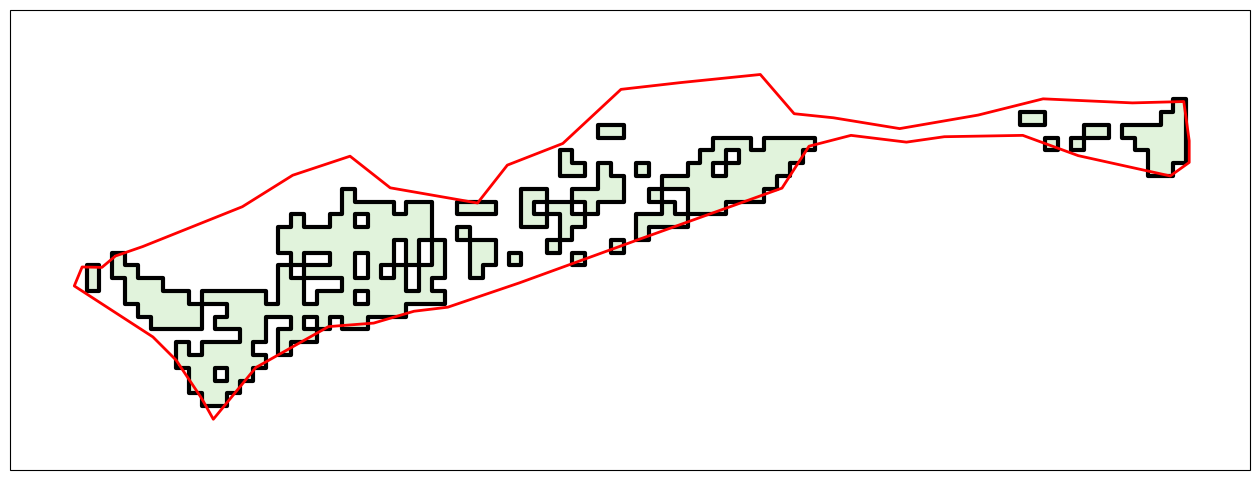

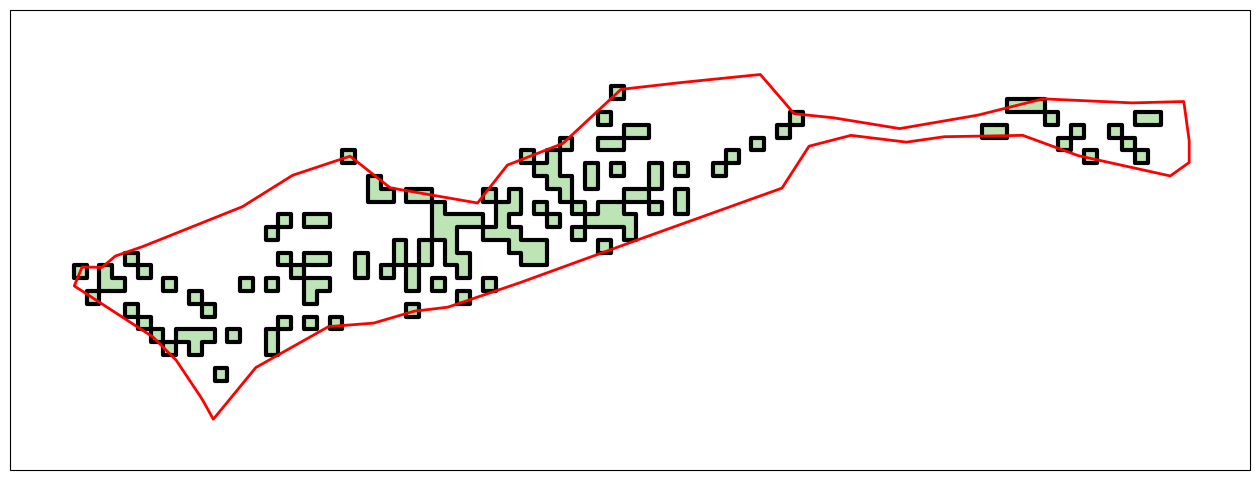

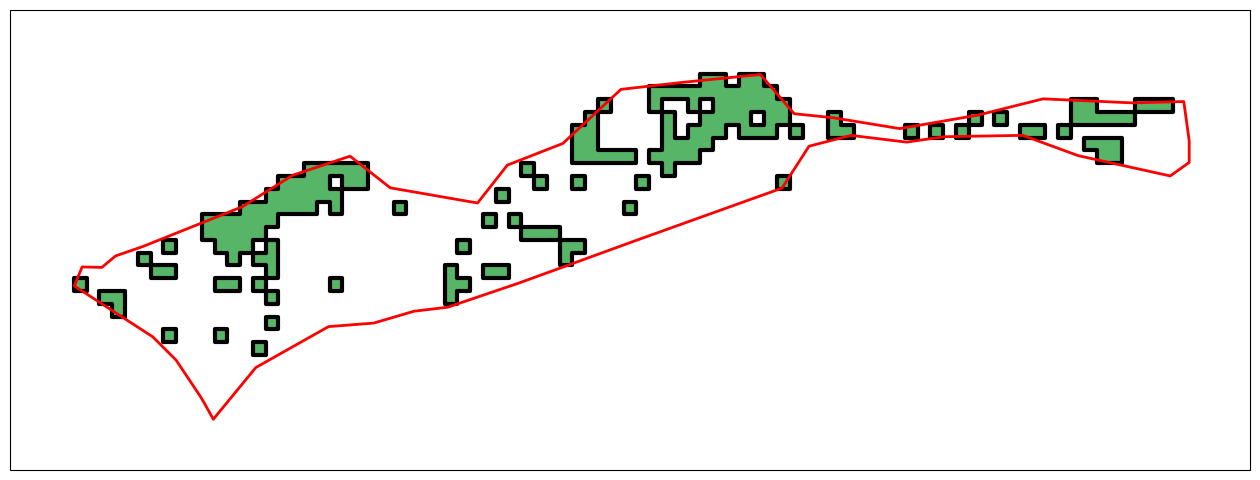

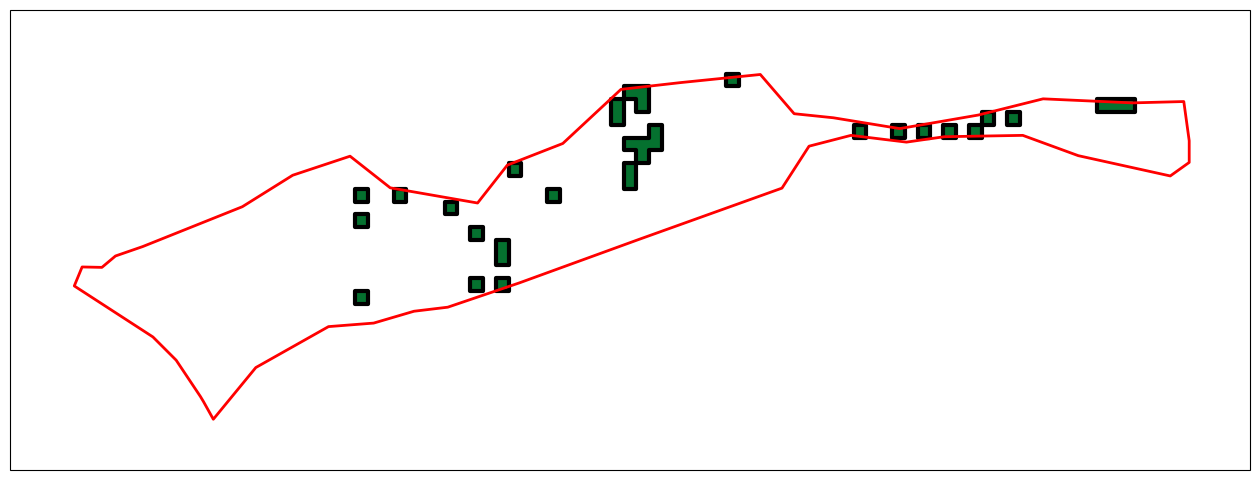

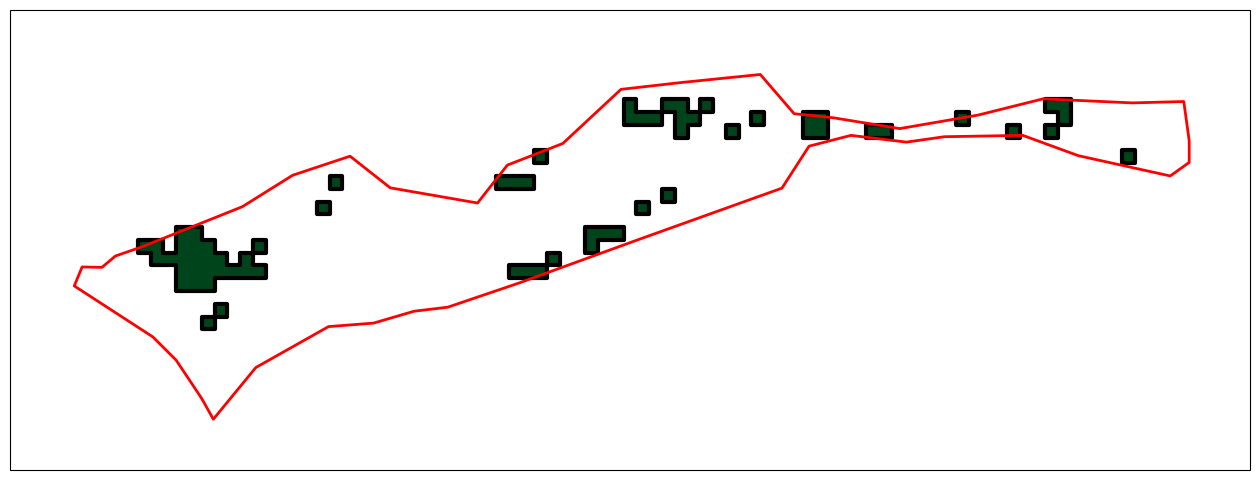

In [58]:
import cartopy.crs as ccrs

zonas = gpd.read_file('shp/zonas_estudio.shp')
zona = zonas[zonas.Id == 1]

proj = ccrs.epsg(25830)

for i, row in fm_pre.iterrows():
    fig = plt.figure(figsize=(16, 10))
    ax = plt.axes(projection=proj)
    
    buffer = 50
    
    bounds =[-9999, 1, 2, 3, 4, 5, 6, 7]
    norm = mpl.colors.Normalize(vmin=1, vmax=7)
    
    minx, miny, maxx, maxy = fm_pre.total_bounds
    # minx_, miny_, maxx_, maxy_ = [transform[2], transform[5] + transform[4] * ds_fm.shape[0], transform[2] + transform[0] * ds_fm.shape[1], transform[5]] 
        
    ax.set_extent([minx - buffer, maxx + buffer, miny - buffer, maxy + buffer], crs=proj)
    fm_pre[fm_pre.value == row.value].plot(ax=ax, facecolor=cmap(row.value/7), edgecolor='black', linewidth=3)
    zona.plot(ax=ax, facecolor=(1,1,1,0), edgecolor='r', linewidth=2)
    # plt.imshow(a[0], cmap='Greens', norm=norm, extent=(minx_, maxx_, miny_, maxy_))
    plt.savefig(f'FINALES/EVOLUCION_HISTOGRAMA/mapa_inicial_{vuelo_pre}_{vuelo_post}_zona{z}_modelo{int(row.value)}.png', bbox_inches = 'tight')

(1, 27, 87)
(1, 27, 87)
(1, 27, 87)
(1, 27, 87)
(1, 27, 87)


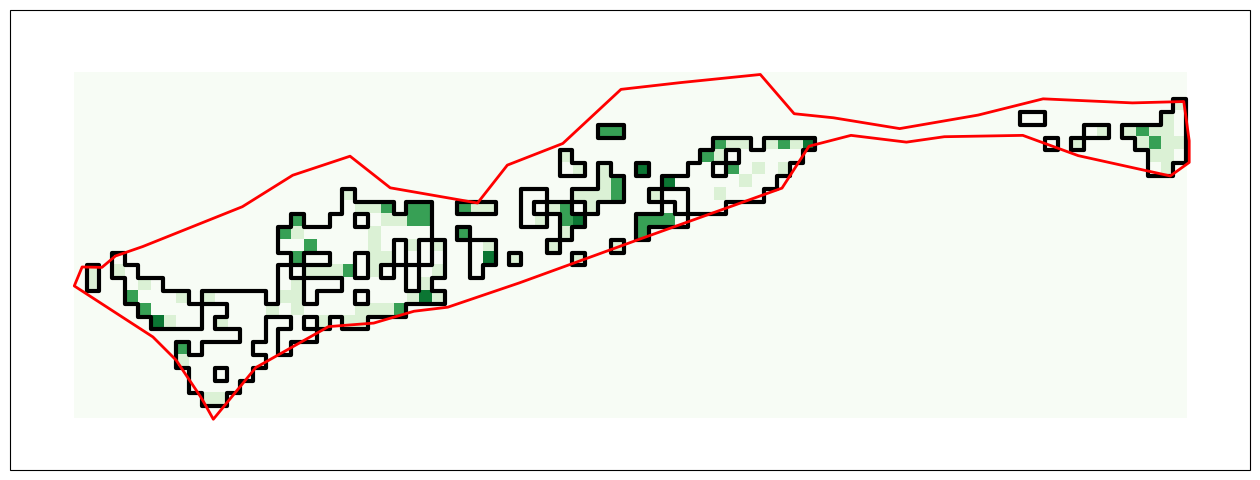

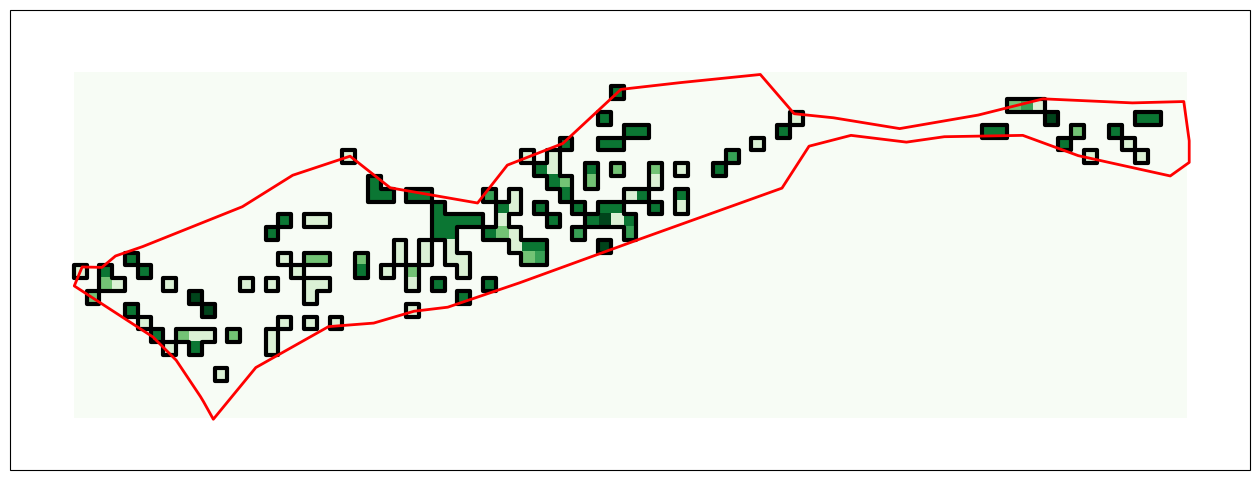

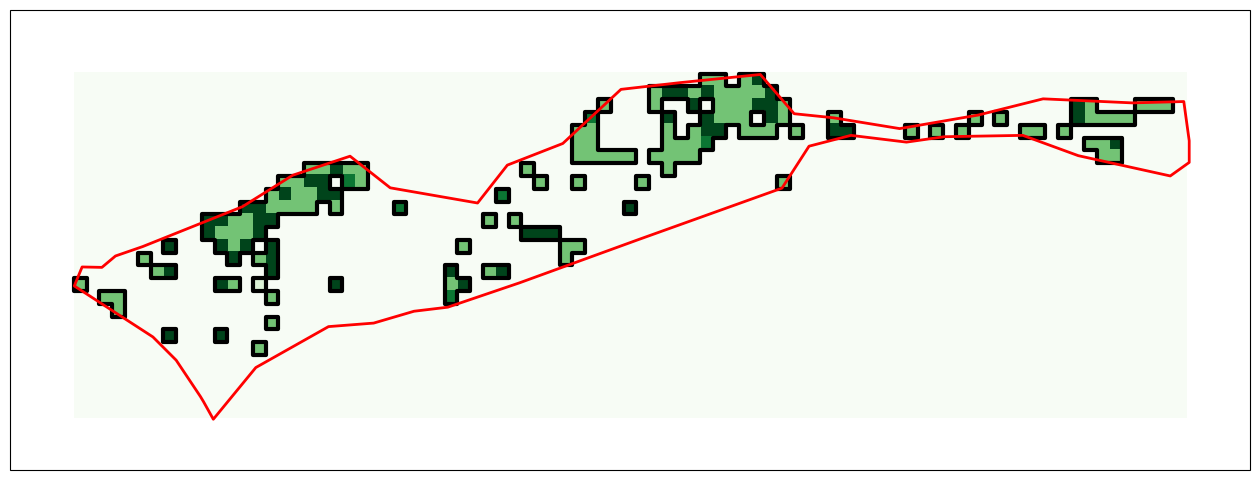

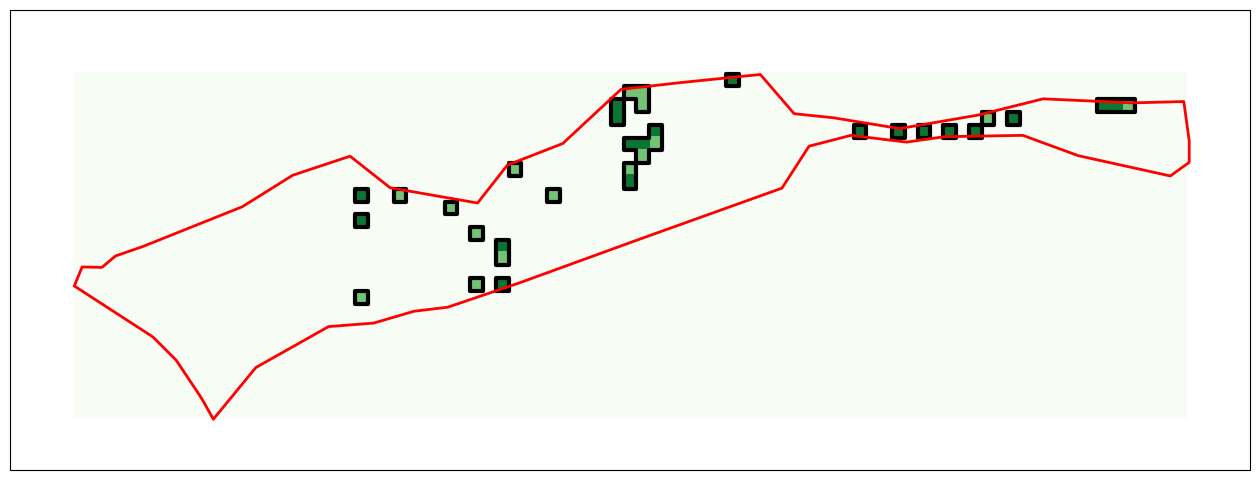

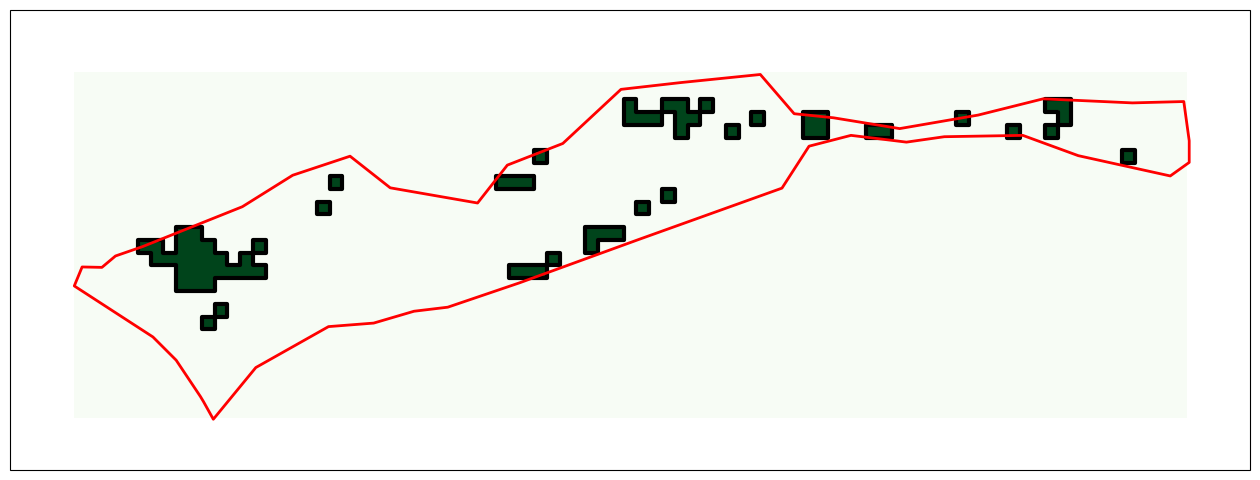

In [63]:
for i, row in fm_pre.iterrows():
    a, b = mask(
        fm_post, 
        [row.geom],
        nodata=-9999
    )
    print(a.shape)
    fig = plt.figure(figsize=(16, 10))
    ax = plt.axes(projection=proj)
    
    buffer = 50
    
    bounds =[-9999, 1, 2, 3, 4, 5, 6, 7]
    norm = mpl.colors.Normalize(vmin=1, vmax=7)
    
    minx, miny, maxx, maxy = fm_pre.total_bounds
    minx_, miny_, maxx_, maxy_ = [b[2], b[5] + b[4] * a.shape[1], b[2] + b[0] * a.shape[2], b[5]] 
        
    ax.set_extent([minx - buffer, maxx + buffer, miny - buffer, maxy + buffer], crs=proj)
    fm_pre[fm_pre.value == row.value].plot(ax=ax, facecolor=(1,1,1,0), edgecolor='black', linewidth=3)
    zona.plot(ax=ax, facecolor=(1,1,1,0), edgecolor='r', linewidth=2)
    plt.imshow(a[0], cmap='Greens', norm=norm, extent=(minx_, maxx_, miny_, maxy_))
    plt.savefig(f'FINALES/EVOLUCION_HISTOGRAMA/mapa_final_{vuelo_pre}_{vuelo_post}_zona{z}_modelo{int(row.value)}.png', bbox_inches = 'tight')   